In [1]:
import HCP
import os, traceback, numpy as np, scipy.stats as stats
from matplotlib import pyplot as plt

CACHE_DIR = './Cache'

In [2]:
set(HCP.INFO['Age in years'])

{22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37}

In [3]:
ages = sorted(list(set(HCP.INFO['Age in years'])))
meanMaps = {}

In [4]:
for age in ages:
    print(f'Age: {age}')
    subs = list(HCP.INFO[HCP.INFO['Age in years'] == age]['Sub'])
    print(f'Subjects: {len(subs)}')
    err = 0
    maps = []
    for sub in subs:
        try:
            maps.append(HCP.getCerebellumMap(sub))
        except:
            print(f'Error when processing Subject {sub}, ignored.')
            err += 1
            continue
    
    print(f'Unprocessed: {err} in {len(subs)}')
    if not maps:
        print('Since not subject data is available, output is skipped.')
        continue
    meanMaps[age] = np.row_stack(maps).mean(axis = 0)

Age: 22
Subjects: 55
Error when processing Subject 196548, ignored.
Error when processing Subject 497764, ignored.
Error when processing Subject 915554, ignored.
Unprocessed: 3 in 55
Age: 23
Subjects: 65
Error when processing Subject 107523, ignored.
Unprocessed: 1 in 65
Age: 24
Subjects: 49
Error when processing Subject 100004, ignored.
Error when processing Subject 263032, ignored.
Error when processing Subject 632037, ignored.
Unprocessed: 3 in 49
Age: 25
Subjects: 78
Error when processing Subject 120818, ignored.
Error when processing Subject 135427, ignored.
Error when processing Subject 141624, ignored.
Error when processing Subject 152932, ignored.
Error when processing Subject 191639, ignored.
Error when processing Subject 211518, ignored.
Error when processing Subject 354944, ignored.
Error when processing Subject 457045, ignored.
Error when processing Subject 940553, ignored.
Unprocessed: 9 in 78
Age: 26
Subjects: 95
Error when processing Subject 104113, ignored.
Error when p

In [18]:
np.save(os.path.join('Data', 'meanMaps'), arr = meanMaps)

In [3]:
maps = np.load(os.path.join('Data', 'meanMaps.npy'), allow_pickle = True).item()
del maps[36], maps[37]

In [4]:
def getOutliers(x):
    Q1, Q3 = stats.scoreatpercentile(x, 25), stats.scoreatpercentile(x, 75)
    IQR = Q3 - Q1
    l, u = Q1 - 2 * IQR, Q3 + 2 * IQR
    return np.where((x - l) * (x - u) > 0)[0]

"""
def _2IQR(x):
    Q1, Q3 = stats.scoreatpercentile(x, 25), stats.scoreatpercentile(x, 75)
    IQR = Q3 - Q1
    return Q1 - 2 * IQR, Q3 + 2 * IQR

def correctedCorr(x, y):
    x_lowerb, x_upperb = _2IQR(x)
    y_lowerb, y_upperb = _2IQR(y)
    normalSet = set(np.where((x - x_lowerb) * (x - x_upperb) <= 0)[0])
    normalSet &= set(np.where((y - y_lowerb) * (y - y_upperb) <= 0)[0])
    normalList = np.array(list(normalSet))
    print(normalList)
    return stats.pearsonr(x[normalList], y[normalList])
"""

def generateMatrix(_array):
    array = np.array(_array)
    length = len(array)
    
    outliers = [getOutliers(i) for i in array]
    combinedOutliers = set()
    for outlier in outliers:
        combinedOutliers |= set(outlier)
    noramls = list(set(np.arange(array.shape[1])) - combinedOutliers)
    print(f'{len(noramls)} / {len(array[0])}')

    matrix = np.zeros((length, length), dtype = np.float64)
    sig = np.zeros((length, length), dtype = np.float64)
    for i in range(length):
        for j in range(length):
            if j < i: matrix[i, j], sig[i, j] = matrix[j, i], sig[j, i]
            else: matrix[i, j], sig[i, j] = stats.pearsonr(array[i][noramls], array[j][noramls])
    return matrix, sig

16215 / 17853


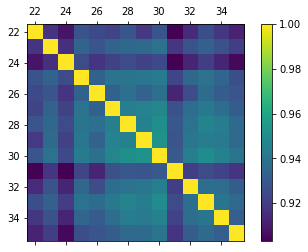

In [53]:
matrix, sig = generateMatrix(list(maps.values()))
plt.figure(figsize = (6, 4))
ax = plt.axes()
cax = ax.matshow(matrix)
plt.xticks([i for i in range(0, 14, 2)], [i + 22 for i in range(0, 14, 2)])
plt.yticks([i for i in range(0, 14, 2)], [i + 22 for i in range(0, 14, 2)])
cb = plt.colorbar(cax)
plt.show()

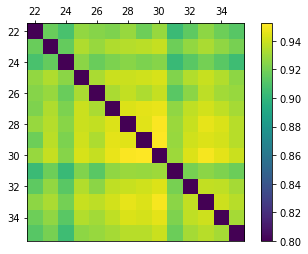

In [75]:
from matplotlib import cm
cmap = cm.viridis
plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
plt.imshow(matrix - np.eye(len(maps)), cmap = cmap, vmin = 0.8)
plt.colorbar()
plt.xticks([i for i in range(0, 14, 2)], [i + 22 for i in range(0, 14, 2)])
plt.yticks([i for i in range(0, 14, 2)], [i + 22 for i in range(0, 14, 2)])
plt.show()